In [1]:
import os
import requests
import re
import sys
import regex as re

In [2]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Imports the Google Cloud client library
from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# %pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
from tensorflow.keras.models import load_model

2023-05-25 01:05:45.636521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 01:05:52.059568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-25 01:05:52.063082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [7]:
%%time
df_filt_2020=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data5_2021_Topics_Sentiments_NER.csv',lineterminator='\n')
df_filt_2021=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data6_2021v2_Topics_Sentiments_NER.csv',lineterminator='\n')
df_filt_2022=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data6_2022_Topics_Sentiments_NER.csv', lineterminator='\n')
df_filt_2023=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data6_2023_Topics_Sentiments_NER.csv', lineterminator='\n')

CPU times: user 1min 52s, sys: 14.2 s, total: 2min 6s
Wall time: 7min 18s


In [9]:
df_filt_all=pd.concat([df_filt_2020, df_filt_2021, df_filt_2022, df_filt_2023])

In [25]:
df_filt_pos=df_filt_all[df_filt_all.sent_label==2]
df_filt_pos.head(2)

Unnamed: 0.1  Unnamed: 0  \
1           1.0           1   
5           5.0           5   

                                                 url        date language  \
1  https://health.economictimes.indiatimes.com/ne...  2020-01-10       en   
5  https://www.connectionsmagazine.com/article/ai...  2020-01-07       en   

                                               title  \
1  artificial intelligence: Researchers develop A...   
5     AI and Machine Learning | Connections Magazine   

                                                text  \
1  \n\nartificial intelligence: Researchers devel...   
5  \n\nAI and Machine Learning | Connections Maga...   

                                        cleaned_text        article_source  \
1   artificial intelligence: Researchers develop ...                   NaN   
5   AI and Machine  Magazine Connections Magazine...  Connections Magazine   

                                         clean_title  ...  \
1  artificial intelligence: Researchers develop A...  ...   
5                            AI and Machine Learning  ...   

                               rake_phrases_articles  \
1  ['economic times ethealthworldhome news hospit...   
5  ['select monthjanuary 2020 11december 2019 1no...   

                                 rake_phrases_joined  final_topic  \
1  economic times ethealthworldhome news hospital...            1   
5  select monthjanuary 2020 11december 2019 1nove...            2   

                                      sent_probs sent_label  \
1  [[1.9508268e-04 8.0524624e-04 9.9899966e-01]]          2   
5  [[2.3212399e-04 1.6879650e-04 9.9959904e-01]]          2   

                                      entities_spacy  \
1  [('AI', 'PRODUCT'), ('Health News', 'ORG'), ('...   
5  [('AI', 'PRODUCT'), ('Machine  Magazine Connec...   

                                             ENT_ORG  \
1  ['Health News', 'ETHealthworld', 'The Economic...   
5  ['Machine  Magazine Connections', 'Home Vendor...   

                                            ENT_PROD  \
1  ['AI', 'NewsJavascript', 'AI', 'AIsystem', 'AI...   
5                                             ['AI']   

                                             ENT_PER                ENT_NORP  
1  ['worldleading uropathologists', 'Martin Eklun...  ['Swedish', 'Chinese']  
5  ['ServiceUs About', 'Peter DeHaan', 'Peter DeH...                      []  

[2 rows x 27 columns]

In [26]:
import ast
df_filt_pos['cleaned_text_tokens']=df_filt_pos['cleaned_text_tokens'].apply(ast.literal_eval)
df_filt_pos['cleaned_tokens_string'] = df_filt_pos['cleaned_text_tokens'].apply(' '.join)

In [27]:
import bertopic
from bertopic import BERTopic

---------

In [ ]:
### Start with sampling

In [ ]:
%%time
df_filt_pos_samp1=df_filt_pos.sample(5_000)
mod_BERT_samp1 = BERTopic(calculate_probabilities=True, njobs=-1)

In [40]:
%%time
topics, probabilities = mod_BERT_samp.fit_transform(df_filt_pos_samp.cleaned_tokens_string.tolist())

CPU times: user 19min 17s, sys: 4min 4s, total: 23min 21s
Wall time: 2min 18s


In [41]:
for i, (k, t) in enumerate(mod_BERT_samp.get_topics().items()):
    topic_words = [x[0] for x in t]
    print(f"Topic {k}: {', '.join(topic_words)}")

Topic -1: ai, data, new, technology, media, business, gray, group, news, platform
Topic 0: market, report, analysis, growth, artificial, intelligence, forecast, global, players, trends
Topic 1: market, report, analysis, growth, global, forecast, key, players, artificial, intelligence
Topic 2: chatgpt, gpt, openai, chatbot, language, said, model, users, text, new
Topic 3: drug, discovery, development, clinical, standigm, pharma, genomics, pharmaceutical, diseases, protein
Topic 4: selfdriving, vehicle, argo, cyclists, vehicles, cyclist, road, traffic, cars, automotive
Topic 5: stocks, etf, stock, nasdaq, bloomberg, news, etfs, investors, markets, investing
Topic 6: customer, laivly, agents, conversational, contact, experience, automation, rasa, vonage, center
Topic 7: education, students, learning, student, courses, artificial, market, intelligence, educational, ai
Topic 8: healthcare, market, medical, artificial, intelligence, patient, health, report, analysis, growth
Topic 9: microsof

In [54]:
mod_BERT_samp1.get_topic_info()

Topic  Count                                               Name
0       -1   1721                          -1_ai_data_new_technology
1        0    172                    0_market_report_analysis_growth
2        1    155                    1_market_report_analysis_growth
3        2    137                       2_chatgpt_gpt_openai_chatbot
4        3     91              3_drug_discovery_development_clinical
..     ...    ...                                                ...
104    103     11             103_semiconductor_darmstadt_kgaa_merck
105    104     11              104_alzheimers_disease_dementia_brain
106    105     11                  105_namco_bucks_deepmotion_bandai
107    106     11           106_sapia_interviewer_greenhouse_avature
108    107     10  107_audiocodes_liveperson_conversational_customer

[109 rows x 3 columns]

In [20]:
%%time

df_filt_pos_samp2=df_filt_pos.sample(10_000)
mod_BERT_samp2 = BERTopic(calculate_probabilities=True, min_topic_size=20, verbose=True)
topics_samp2, probabilities_samp2 = mod_BERT_samp2.fit_transform(df_filt_pos_samp2.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-05-23 13:42:49,530 - BERTopic - Transformed documents to Embeddings
2023-05-23 13:43:24,287 - BERTopic - Reduced dimensionality
2023-05-23 13:43:29,338 - BERTopic - Clustered reduced embeddings


CPU times: user 25min 40s, sys: 4min 55s, total: 30min 35s
Wall time: 4min 51s


In [22]:
mod_BERT_samp2.get_topic_info().head(20)

Topic  Count                                        Name
0      -1   3796                       -1_ai_data_new_market
1       0    308  0_customer_conversational_voice_experience
2       1    292                    1_ai_data_business_india
3       2    233             2_market_report_analysis_growth
4       3    215             3_military_defense_air_aircraft
5       4    211                4_edge_edgecortix_jun_design
6       5    191   5_market_intelligence_artificial_analysis
7       6    178                6_chatgpt_openai_gpt_chatbot
8       7    161                  7_stocks_stock_markets_buy
9       8    160                    8_job_hiring_jobs_talent
10      9    135           9_drug_discovery_genomics_protein
11     10    122              10_news_schedule_public_wfmztv
12     11    120     11_healthcare_market_medical_artificial
13     12    118        12_vehicle_selfdriving_argo_vehicles
14     13    117      13_retailers_retail_shopping_ecommerce
15     14    107         14_financial_fraud_blockchain_banks
16     15    103                  15_nvidia_nvidias_gpu_gpus
17     16    100               16_healthcare_health_care_osf
18     17     99                  17_adobe_video_art_content
19     18     89        18_microsoft_openai_azure_microsofts

In [23]:
%%time

df_filt_pos_samp3=df_filt_pos.sample(20_000)
mod_BERT_samp3 = BERTopic(calculate_probabilities=True, min_topic_size=40, verbose=True)
topics_samp3, probabilities_samp3 = mod_BERT_samp3.fit_transform(df_filt_pos_samp3.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2023-05-23 13:53:33,621 - BERTopic - Transformed documents to Embeddings
2023-05-23 13:53:45,435 - BERTopic - Reduced dimensionality
2023-05-23 13:53:56,540 - BERTopic - Clustered reduced embeddings


CPU times: user 1h 10min 27s, sys: 14min 56s, total: 1h 25min 24s
Wall time: 9min 19s


In [25]:
mod_BERT_samp3.get_topic_info().head(20)

Topic  Count                                          Name
0      -1   8628                         -1_ai_data_media_gray
1       0   2352          0_health_healthcare_medical_clinical
2       1    476               1_market_report_analysis_global
3       2    384                  2_ai_business_data_companies
4       3    382       3_market_artificial_intelligence_report
5       4    376                  4_chatgpt_gpt_openai_chatbot
6       5    328             5_automotive_vehicle_traffic_cars
7       6    251                   6_energy_climate_grid_water
8       7    251                 7_defense_military_shield_dod
9       8    226                  8_nvidia_gpu_gpus_supermicro
10      9    214                    9_edge_design_ip_processor
11     10    212  10_customer_conversational_experience_laivly
12     11    209               11_microsoft_bing_openai_search
13     12    207                  12_republic_news_local_email
14     13    181        13_retailers_retail_ecommerce_shopping
15     14    177                     14_shares_nasdaq_etf_nyse
16     15    172     15_security_cyber_cybersecurity_darktrace
17     16    158         16_voice_conversational_verbit_speech
18     17    156                  17_credit_zest_union_members
19     18    153             18_machine_learning_market_report

-----
### Running on all positive articles

In [26]:
%%time
mod_BERT_pos = BERTopic(calculate_probabilities=True, verbose=True, min_topic_size=50)
topics_pos, probabilities_pos = mod_BERT_pos.fit_transform(df_filt_pos.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/1903 [00:00<?, ?it/s]

2023-05-23 14:28:16,527 - BERTopic - Transformed documents to Embeddings
2023-05-23 14:29:02,626 - BERTopic - Reduced dimensionality
2023-05-23 14:35:30,440 - BERTopic - Clustered reduced embeddings


CPU times: user 4h 11min 23s, sys: 49min 51s, total: 5h 1min 15s
Wall time: 37min 31s


In [33]:
mod_BERT_pos.get_topic_info().head(20)

Topic  Count                                         Name
0      -1  24312                        -1_ai_gray_media_data
1       0   1296              0_market_analysis_report_growth
2       1    952    1_market_artificial_intelligence_analysis
3       2    942         2_healthcare_market_medical_medicine
4       3    834      3_automotive_digitalq_vehicle_september
5       4    785                 4_chatgpt_gpt_openai_chatbot
6       5    596  5_customer_conversational_experience_agents
7       6    596                        6_edge_ip_design_chip
8       7    575                    7_nvidia_nvidias_gpus_gpu
9       8    541                     8_adobe_images_image_art
10      9    429              9_banking_fraud_financial_banks
11     10    398             10_machine_learning_market_mlaas
12     11    371           11_covid_coronavirus_virus_vaccine
13     12    371          12_retail_retailers_stores_shopping
14     13    360                13_military_defense_dod_force
15     14    351     14_agriculture_farmers_crop_agricultural
16     15    317              15_india_indias_indian_minister
17     16    295           16_diabetic_retinopathy_eyeart_eye
18     17    292              17_science_skills_students_data
19     18    281                      18_saudi_uae_arabia_abu

In [34]:
df_filt_pos['Bert_topics']=mod_BERT_pos.topics_

In [41]:
df_filt_pos['Bert_topics_words'] = df_filt_pos['Bert_topics'].apply(lambda x: mod_BERT_pos.get_topic(x))

In [46]:
df_filt_pos.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_POS_BERTopics_Sentiments_NER.csv',index=False)

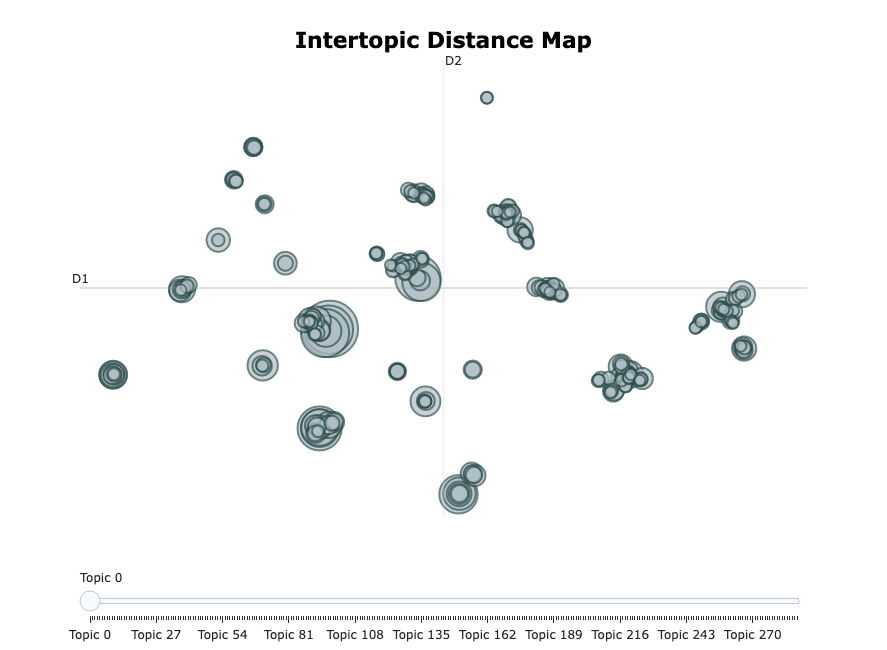

In [73]:
mod_BERT_pos.visualize_topics()

----
### Running on all Negative articles

In [28]:
%%time
df_filt_neg=df_filt_all[df_filt_all.sent_label==0]
df_filt_neg['cleaned_text_tokens']=df_filt_neg['cleaned_text_tokens'].apply(ast.literal_eval)
df_filt_neg['cleaned_tokens_string'] = df_filt_neg['cleaned_text_tokens'].apply(' '.join)

mod_BERT_neg = BERTopic(calculate_probabilities=True, verbose=True)
topics_neg, probabilities_neg = mod_BERT_neg.fit_transform(df_filt_neg.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2023-05-23 14:39:21,910 - BERTopic - Transformed documents to Embeddings
2023-05-23 14:39:28,403 - BERTopic - Reduced dimensionality
2023-05-23 14:39:31,574 - BERTopic - Clustered reduced embeddings


CPU times: user 19min 22s, sys: 3min 38s, total: 23min
Wall time: 2min 35s


In [32]:
mod_BERT_neg.get_topic_info().head(20)

Topic  Count                                    Name
0      -1   1054                     -1_ai_data_new_news
1       0    125  0_clearview_facial_recognition_privacy
2       1    104           1_weather_search_county_hours
3       2    103         2_guardforce_gfai_limited_stock
4       3    100      3_deals_industry_financing_venture
5       4     79           4_bard_google_chatbot_googles
6       5     68          5_link_machine_learning_dollar
7       6     64                 6_edt_apr_lebanon_pixel
8       7     64              7_gebru_google_fired_paper
9       8     61    8_health_medical_healthcare_patients
10      9     59          9_students_chatgpt_teachers_te
11     10     59        10_italy_italian_replika_chatgpt
12     11     59   11_decentralized_machine_learning_dml
13     12     56             12_renalytix_plan_video_etf
14     13     54                   13_ernie_baidu_bot_li
15     14     53         14_matrix_network_traded_dollar
16     15     52         15_ses_corporation_stock_shares
17     16     52         16_lisk_machine_learning_dollar
18     17     49      17_stocks_stock_investorplace_fell
19     18     47         18_renalytix_rnlx_shares_nasdaq

In [47]:
df_filt_neg['Bert_topics']=mod_BERT_neg.topics_
df_filt_neg['Bert_topics_words'] = df_filt_neg['Bert_topics'].apply(lambda x: mod_BERT_neg.get_topic(x))
df_filt_neg.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_NEG_BERTopics_Sentiments_NER.csv',index=False)

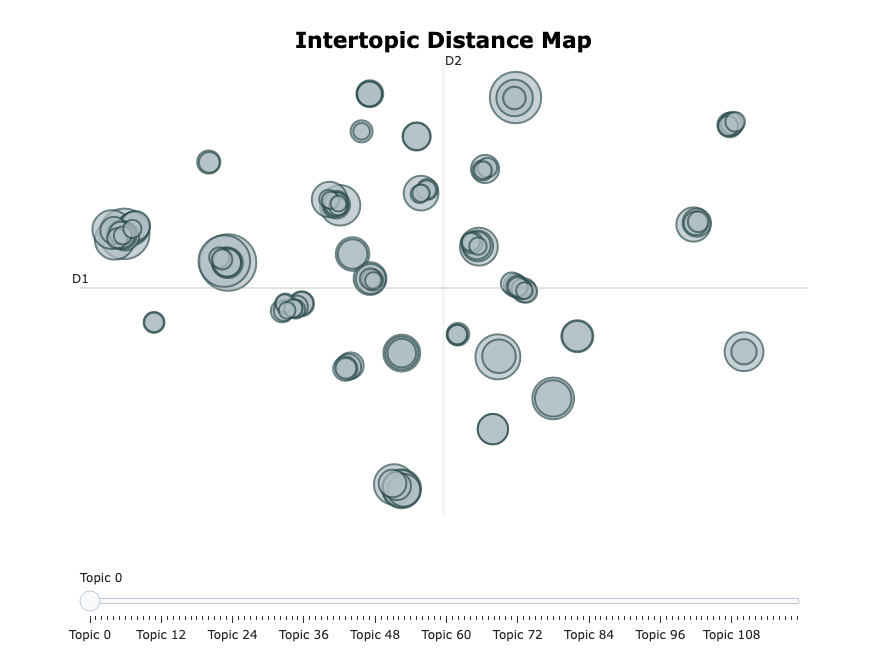

In [72]:
mod_BERT_neg.visualize_topics()

---
### Checking for groups of topics


In [71]:
mod_BERT_neg.save('mod_BERT_neg.h5')
mod_BERT_pos.save('mod_BERT_pos.h5')

In [46]:
# Model saving error

In [28]:
%%time
mod_BERT_pos = BERTopic(calculate_probabilities=True, verbose=True, min_topic_size=50)
topics_pos, probabilities_pos = mod_BERT_pos.fit_transform(df_filt_pos.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/1903 [00:00<?, ?it/s]

2023-05-23 22:33:11,830 - BERTopic - Transformed documents to Embeddings
2023-05-23 22:34:16,336 - BERTopic - Reduced dimensionality
2023-05-23 22:41:37,574 - BERTopic - Clustered reduced embeddings


CPU times: user 2h 34min 18s, sys: 29min 43s, total: 3h 4min 2s
Wall time: 33min 50s


In [34]:
mod_BERT_pos.save("Impact_Analysis_GenAI/mod_BERT_pos_new")

FileNotFoundError: [Errno 2] No such file or directory: 'Impact_Analysis_GenAI/mod_BERT_pos_new'

In [30]:
mod_BERT_pos.get_topic_info().head(20)

Topic  Count                                         Name
0      -1  23297                         -1_ai_data_new_media
1       0   1288              0_market_analysis_report_growth
2       1    943    1_market_artificial_intelligence_analysis
3       2    940         2_healthcare_market_medical_medicine
4       3    872        3_automotive_digitalq_vehicle_traffic
5       4    755                 4_chatgpt_gpt_openai_chatbot
6       5    669           5_defense_military_shield_aircraft
7       6    667           6_business_employees_ai_automation
8       7    653                    7_hailo_edge_processor_ip
9       8    649                    8_nvidia_nvidias_gpus_gpu
10      9    638  9_customer_conversational_experience_agents
11     10    437           10_banking_financial_fraud_fintech
12     11    397             11_machine_learning_market_mlaas
13     12    385           12_covid_coronavirus_virus_vaccine
14     13    366          13_retail_retailers_stores_shopping
15     14    359              14_india_indias_indian_minister
16     15    355     15_agriculture_farmers_crop_agricultural
17     16    289                      16_saudi_uae_arabia_abu
18     17    276                 17_venturebeat_follow_vb_rss
19     18    265           18_science_students_courses_skills

In [ ]:
## Saving to V2 if required later

df_filt_pos['Bert_topics']=mod_BERT_pos.topics_
df_filt_pos['Bert_topics_words'] = df_filt_pos['Bert_topics'].apply(lambda x: mod_BERT_pos.get_topic(x))


In [32]:
df_filt_pos.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v2_POS_BERTopics_Sentiments_NER.csv',index=False)

In [54]:
mod_BERT_pos_newl=BERTopic.load("mod_BERT_pos_new")
mod_BERT_pos_newl

In [55]:
# We will try to reduce the number of programs
print("Number of topics:", mod_BERT_pos_newl.get_topic_freq().shape[0])

Number of topics: 297


In [56]:
%%time
mod_BERT_pos_newr=mod_BERT_pos_newl.reduce_topics(df_filt_pos.cleaned_tokens_string.tolist(), nr_topics=60)
mod_BERT_pos_newr

2023-05-24 02:01:40,635 - BERTopic - Reduced number of topics from 297 to 60


CPU times: user 1min 24s, sys: 2.47 s, total: 1min 27s
Wall time: 1min 12s


In [61]:
# We will try to reduce the number of programs
print("Number of topics:", mod_BERT_pos_newr.get_topic_freq().shape[0])

Number of topics: 60


In [59]:
mod_BERT_pos_newr.get_topic_info().head(30)

Topic  Count                                            Name
0      -1  23297                       -1_ai_data_new_technology
1       0  17235                 0_market_ai_intelligence_global
2       1   2173                  1_chatgpt_openai_gpt_microsoft
3       2   2025        2_healthcare_market_medical_intelligence
4       3   1846                    3_stock_shares_nasdaq_stocks
5       4   1077            4_defense_aviation_military_aircraft
6       5   1071           5_automotive_vehicle_traffic_digitalq
7       6    961                            6_nvidia_gpu_gpus_ai
8       7    725                          7_india_saudi_uae_news
9       8    711                    8_baidu_china_baidus_chinese
10      9    691               9_education_students_science_data
11     10    579                   10_legal_insurance_law_estate
12     11    569                 11_financial_bank_banking_fraud
13     12    549                          12_africa_new_south_ai
14     13    544                    13_music_voice_rights_verbit
15     14    517          14_security_cybersecurity_cyber_market
16     15    492                               15_est_pm_apr_jan
17     16    440          16_covid_coronavirus_virus_favipiravir
18     17    366             17_retail_retailers_stores_shopping
19     18    355              18_agriculture_farmers_market_crop
20     19    253                       19_gold_gpt_tire_polestar
21     20    231              20_diabetic_retinopathy_eye_eyeart
22     21    218   21_genesys_conversational_cognigy_marketscape
23     22    214                      22_energy_solar_power_grid
24     23    209                  23_ddn_storage_ddns_cardiologs
25     24    205            24_dental_overjet_dentistry_dentists
26     25    195       25_synthetic_synthesis_rendered_materials
27     26    164  26_sanctuary_guardforce_duality_generalpurpose
28     27    160              27_republic_viettel_notices_submit
29     28    160               28_wearable_fashion_market_report

In [60]:
mod_BERT_pos_newr.save('mod_BERT_pos_newr')

In [62]:
## Saving to V3 for later

df_filt_pos['Bert_topics']=mod_BERT_pos_newr.topics_
df_filt_pos['Bert_topics_words'] = df_filt_pos['Bert_topics'].apply(lambda x: mod_BERT_pos_newr.get_topic(x))
df_filt_pos.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v3_POS_BERTopics_Sentiments_NER.csv',index=False)

-----
### Negative

In [39]:
%%time
df_filt_neg=df_filt_all[df_filt_all.sent_label==0]
df_filt_neg['cleaned_text_tokens']=df_filt_neg['cleaned_text_tokens'].apply(ast.literal_eval)
df_filt_neg['cleaned_tokens_string'] = df_filt_neg['cleaned_text_tokens'].apply(' '.join)

mod_BERT_neg = BERTopic(calculate_probabilities=True, verbose=True)
topics_neg, probabilities_neg = mod_BERT_neg.fit_transform(df_filt_neg.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2023-05-24 01:38:11,808 - BERTopic - Transformed documents to Embeddings
2023-05-24 01:38:18,095 - BERTopic - Reduced dimensionality
2023-05-24 01:38:21,089 - BERTopic - Clustered reduced embeddings


CPU times: user 18min 36s, sys: 3min 49s, total: 22min 25s
Wall time: 2min 34s


In [40]:
print("Number of topics:", mod_BERT_neg.get_topic_freq().shape[0])

Number of topics: 121


In [41]:
mod_BERT_neg.get_topic_info().head(30)

Topic  Count                                      Name
0      -1   1101                       -1_ai_data_new_said
1       0    188            0_republic_news_sports_weather
2       1    103           1_guardforce_gfai_limited_stock
3       2     76             2_bard_google_chatbot_googles
4       3     69            3_link_machine_learning_dollar
5       4     65                 4_npr_bard_schedule_radio
6       5     61            5_students_teachers_chatgpt_te
7       6     61           6_renalytix_rnlx_quarter_shares
8       7     59           7_italy_italian_replika_chatgpt
9       8     54            8_ses_corporation_stock_shares
10      9     54                  9_musk_tesla_elon_openai
11     10     54           10_matrix_network_traded_dollar
12     11     53     11_health_medical_healthcare_patients
13     12     52               12_gebru_google_fired_paper
14     13     52          13_renalytix_video_etf_bloomberg
15     14     51           14_lisk_machine_learning_dollar
16     15     49          15_stocks_stock_investorplace_ai
17     16     48     16_decentralized_machine_learning_dml
18     17     45  17_decentralized_machine_learning_traded
19     18     45            18_bing_microsoft_search_opens
20     19     44           19_matrix_network_traded_dollar
21     20     44          20_snapchat_users_chatbot_creepy
22     21     43                     21_ernie_baidu_bot_li
23     22     43      22_vectorspace_baskets_dollar_trades
24     23     42          23_ai_consciousness_systems_data
25     24     38                 24_agobl_hours_sa_january
26     25     38           25_china_chinese_chatgpt_chinas
27     26     38                 26_startups_tech_cmc_fund
28     27     37        27_clearview_facial_recognition_uk
29     28     37                28_nvidia_chips_china_chip

In [42]:
mod_BERT_neg.reduce_topics(df_filt_neg.cleaned_tokens_string.tolist(), nr_topics=40)

2023-05-24 01:43:05,252 - BERTopic - Reduced number of topics from 121 to 40


In [43]:
print("Number of topics:", mod_BERT_neg.get_topic_freq().shape[0])

Number of topics: 40


In [44]:
mod_BERT_neg.get_topic_info().head(20)

Topic  Count                                      Name
0      -1   1101                       -1_ai_data_new_news
1       0    771                0_traded_dollar_btc_trades
2       1    316              1_google_bard_search_googles
3       2    303                 2_stock_shares_stocks_ses
4       3    261           3_market_data_analysis_industry
5       4    225                4_news_republic_new_sports
6       5    143             5_chat_users_snapchat_chatgpt
7       6    126               6_schedule_radio_npr_public
8       7    118         7_customer_cujo_respondents_italy
9       8    116                     8_ai_workers_job_jobs
10      9    102               9_china_chinese_chinas_news
11     10     92  10_ai_intelligence_technology_artificial
12     11     78                     11_ernie_bot_baidu_li
13     12     77     12_health_medical_healthcare_patients
14     13     73           13_renalytix_shares_rnlx_nasdaq
15     14     65                14_nvidia_chips_chip_china
16     15     61    15_students_chatgpt_teachers_education
17     16     55             16_images_features_russia_imf
18     17     54                 17_musk_tesla_elon_openai
19     18     53   18_clearview_facial_recognition_privacy

In [63]:
mod_BERT_neg.save('mod_BERT_neg')

In [64]:
%%time
## Saving to V3 for later

df_filt_neg['Bert_topics']=mod_BERT_neg.topics_
df_filt_neg['Bert_topics_words'] = df_filt_neg['Bert_topics'].apply(lambda x: mod_BERT_neg.get_topic(x))
df_filt_neg.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v3_NEG_BERTopics_Sentiments_NER.csv',index=False)

CPU times: user 6.13 s, sys: 111 ms, total: 6.24 s
Wall time: 10.1 s


----
### Trying to be more inclusive of negative articles

Decreasing the threshold for negative articles

In [29]:
import ast
df_filt_all['sent_probs_proc']=df_filt_all['sent_probs'].parallel_apply(lambda x: x.split(' '))

In [32]:
df_filt_all['sent_probs_proc'].info()

<class 'pandas.core.series.Series'>
Int64Index: 186815 entries, 0 to 56338
Series name: sent_probs_proc
Non-Null Count   Dtype 
--------------   ----- 
186815 non-null  object
dtypes: object(1)
memory usage: 6.9+ MB
